# Caso studio Pilgrim Bank
Gianluigi Lopardo, 277268

* 1. [Introduzione](#intro)
  * 1.1 [Informazioni sugli attributi](#info)
* 2. [Esplorazione dei dati](#esplorazione)
* 3. [Oversampling](#oversampling)
* 4. [Classificazione](#classificazione)
  * 4.1 [Regressione logistica](#logistica)
  * 4.2 [K Nearest Neighbours](#knn)
  * 4.3 [Support Vector Machine](#svm)
  * 4.4 [Alberi di decisione](#tree)
  * 4.5 [Random Forest](#forest)
* 5. [Conclusioni](#conclusioni)

# 1. <a class="anchor" id="intro">Introduzione</a>
Il dataset contiene dati su alcuni clienti della Pilgrim Bank negli anni 1999 e 2000.

Lo scopo di questo lavoro è prevedere quali sono i clienti che stanno per lasciare la banca. Per farlo, verrano utilizzati i principali algoritmi di classificazione per prevedere se un cliente del 1999 lo sarà ancora nel 2000 o meno.

Uno studio di questo tipo può essere molto importante: suggerisce ad un'azienda con anticipo quali sono i clienti che probabilmente sta per prendere. Avendo questa informazione, a seconda che il cliente sia sufficientemente profittevole o meno, l'azienda può ad esempio valutare di investire sul cliente offrendogli nuovi prodotto e/o servizi.

## 1.1 <a class="anchor" id="info">Informazioni sugli attributi</a>
Prima di esplorare il dataset, e di conseguenza costruire opportuni modelli, vediamo quali sono gli attributi a disposizione.

* *ID*: identificativo
* *X9Profit, X0Profit*: profitto ricavato dal clienti nel 1999 e nel 2000
* *X9Online, X0Online*: indica se l'utente utilizza o meno i servizi online della banca (0, 1)
* *X9Age*: età nel 1999
* *X9Inc*: fascia reddito 
* *X9Tenure*: tempo di possesso del cliente
* *X9District*: distretto geografico

# 2. <a class="anchor" id="esplorazione">Esplorazione dei dati</a>



In [1]:
#scientific
import pandas as pd 
import numpy as np
import math

#models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#oversampling
from imblearn.over_sampling import SMOTE

#plot
import matplotlib.pyplot as plt

SEED = 42

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
url = "https://raw.githubusercontent.com/gianluigilopardo/bank_prediction/master/Pilgrim.csv"
df = pd.read_csv(url, sep=',')
df.head()

,ID,9Profit,9Online,9Age,9Inc,9Tenure,9District,0Profit,0Online,9Billpay,0Billpay
0,1,21,0,NaN,NaN,6.33,1200,NaN,NaN,0,NaN
1,2,-6,0,6.0,3.0,29.50,1200,-32.0,0.0,0,0.0
2,3,-49,1,5.0,5.0,26.41,1100,-22.0,1.0,0,0.0
3,4,-4,0,NaN,NaN,2.25,1200,NaN,NaN,0,NaN
4,5,-61,0,2.0,9.0,9.91,1200,-4.0,0.0,0,0.0


Dobbiamo fare previsioni sull'anno 2000, avendo a disposizione i dati dell'anno precedente. 
Procediamo quindi tenendo nel dataset solo le informazioni del 1999 e l'attributo *0Profit*, che rappresenta il nostro target.

In [3]:
df = df[['9Profit', '9Online', '9Age', '9Inc', '9Tenure', '9District', '0Profit']]

In [4]:
print("Il dataset contiene %d righe e %d colonne." % df.shape)
df.head()

Il dataset contiene 31634 righe e 7 colonne.


,9Profit,9Online,9Age,9Inc,9Tenure,9District,0Profit
0,21,0,NaN,NaN,6.33,1200,NaN
1,-6,0,6.0,3.0,29.50,1200,-32.0
2,-49,1,5.0,5.0,26.41,1100,-22.0
3,-4,0,NaN,NaN,2.25,1200,NaN
4,-61,0,2.0,9.0,9.91,1200,-4.0


L'attributo *9District* assume valore intero, ma difatto va gestito come cateoorico.

In [5]:
df['9District'].value_counts()

1200    24342
1300     4150
1100     3142
Name: 9District, dtype: int64

Vediamo che assume tre valori diversi. Una soluzione possibile è quella di aggiungere tre variabili dummy che assumono 1 in corrispondenza del distretto giusto, 0 altrimenti.

In [6]:
def d1200(x):
 if x['9District'] == 1200:
  return 1
 else:
  return 0
df['d1200'] = df.apply(lambda x: d1200(x), axis=1)
  
def d1300(x):
 if x['9District'] == 1300:
  return 1
 else:
  return 0 
df['d1300'] = df.apply(lambda x: d1300(x), axis=1)

def d1100(x):
 if x['9District'] == 1100:
  return 1
 else:
  return 0   
df['d1100'] = df.apply(lambda x: d1100(x), axis=1)

Occupiamoci ora dei valori mancanti.

In [7]:
print(str(len(df)-df.count()))

9Profit         0
9Online         0
9Age         8289
9Inc         8261
9Tenure         0
9District       0
0Profit      5238
d1200           0
d1300           0
d1100           0
dtype: int64


I valori mancanti di *0Profit* rappresentano i clienti che hanno lasciato la banca e sono pertanto di nostro interesse.

Creiamo un nuovo attributo *cliente* che assume valore 1 se il record corrisponde ad un cliente ancora attivo nel 2000 (quindi con *0Profit* presente), 0 altrimenti (se *0Profit* manca).


In [8]:
def cliente(x):
  if math.isnan(x['0Profit']):
    return 0
  else:
    return 1
df['cliente'] = df.apply(lambda x: cliente(x), axis = 1)
df = df.drop('0Profit', axis = 1)
df

,9Profit,9Online,9Age,9Inc,9Tenure,9District,d1200,d1300,d1100,cliente
0,21,0,NaN,NaN,6.33,1200,1,0,0,0
1,-6,0,6.0,3.0,29.50,1200,1,0,0,1
2,-49,1,5.0,5.0,26.41,1100,0,0,1,1
3,-4,0,NaN,NaN,2.25,1200,1,0,0,0
4,-61,0,2.0,9.0,9.91,1200,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
31629,-50,0,5.0,5.0,3.75,1200,1,0,0,1
31630,458,0,3.0,8.0,12.08,1300,0,1,0,1
31631,-83,0,6.0,4.0,15.83,1200,1,0,0,1
31632,92,1,1.0,6.0,5.41,1200,1,0,0,1


*9Age* e *9Inc* presentano molti valori mancanti. Verosimilmente, l'età e il reddito sono informazioni facoltative, che alcuni clienti hanno deciso di non dare alla banca.

In [9]:
na = len(df) - len(df.dropna())
n = len(df)
print(str(na) + ' record su ' + str(n) + ' hanno almeno un valore mancante, quindi circa il ' + 
      str(round(100*na/n, 2)) + '% del totale.')

8822 record su 31634 hanno almeno un valore mancante, quindi circa il 27.89% del totale.


Rimuovere una parte così grande del dataset potrebbe far perdere troppe informazioni. Tuttavia l'alternativa è quella di sostituire i valori mancanti col valore medio dell'attributo corrispondente, che potrebbe distorcere i risultati. 

Proseguiamo lavorando con entrambe queste opzioni e infine, confrontando le prestazioni dei modelli potremo valutare quale sia la scelta migliore.

Nel secondo caso, per tener comunque conto del fatto che gli attributi fossero mancanti, aggiungiamo due variabili dummy *AgeExists* e *IncomeExists*, che poniamo uguali a 1 quando il relativo attributo era presente e 0 quando è stato sostituito col valore medio.

In [10]:
df_drop = df.dropna().copy()

df['AgeExist'] = df['9Age'].isna().apply(lambda x: 1 if x==0 else 0)
df['IncomeExists'] = df['9Inc'].isna().apply(lambda x: 1 if x==0 else 0)
df['9Age'].fillna(df['9Age'].mean(), inplace = True)
df['9Inc'].fillna(df['9Inc'].mean(), inplace = True)

Diviamo quindi i due dataset in *training set* e *test set*, con rispettivamente il 70% e il 30% dei dati.

In [11]:
X_mean = df.drop('cliente', axis = 1)
y_mean = df['cliente']
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean, y_mean, test_size = 0.3, random_state = SEED)

X_drop = df_drop.drop('cliente', axis = 1)
y_drop = df_drop['cliente']
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size = 0.3, random_state = SEED)

Vediamo per entrambi i dataset quanti sono i clienti persi nel 2000.

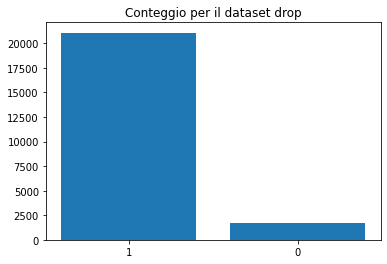

In [12]:
# drop
uno = len(y_drop[y_drop == 1])
zero = len(y_drop[y_drop == 0])
x = np.array(['1', '0'])
y = np.array([uno, zero])
plt.bar(x, y)
plt.title('Conteggio per il dataset drop')
plt.show()

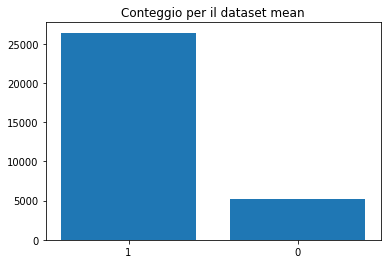

In [13]:
# mean
uno = len(y_mean[y_mean == 1])
zero = len(y_mean[y_mean == 0])
x = np.array(['1', '0'])
y = np.array([uno, zero])
plt.bar(x, y)
plt.title('Conteggio per il dataset mean')
plt.show()

In entrambi i casi il dataset è fortemente sbilanciato: il numero di record delle classi è troppo diverso. 
Questo era atteso, il numero di clienti che abbandona è piccolo rispetto al totale.

Lo sbilanciamento può portare a forti distorsioni nella classificazione, è necessario gestire questo problema.

# 3. <a class="anchor" id="oversampling">Oversampling</a>

L'idea è quella di generare nuovi record "fittizzi" da aggiungere alla classe minoritaria, in modo da riequilibrare il dataset.

La tecnica più comune per farlo è **SMOTE** (Synthetic Minority Oversampling Technique): preso un record dal datast, si considerano i suoi $k$ record più vicini. Per creare un punto, si prende il vettore tra uno di quei $k$ vicini e il record e si seleziona una posizione su questo vettore prendendo un numero casuale $x$ tra $0$ e $1$. 

In [14]:
X_SMOTE_mean, y_SMOTE_mean = SMOTE(random_state = SEED).fit_resample(X_train_mean, y_train_mean)
X_SMOTE_drop, y_SMOTE_drop = SMOTE(random_state = SEED).fit_resample(X_train_drop, y_train_drop)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [15]:
print('-MEAN: \n' +
      'Nel dataset SMOTE la classe 0 ha ' + str(len(y_SMOTE_mean[y_SMOTE_mean == 0])) + 
      ' record. La classe 1 ne ha ' + str(len(y_SMOTE_mean[y_SMOTE_mean == 1])) + '.\n' +
      'Nel training set di partenza la classe 0 ha ' + str(len(y_train_mean[y_train_mean == 0])) + 
      ' record. La classe 1 ne ha ' + str(len(y_train_mean[y_train_mean == 1])) + '.\n' +
      '-DROP: \n' + 
      'Nel dataset SMOTE la classe 0 ha ' + str(len(y_SMOTE_drop[y_SMOTE_drop == 0])) + 
      ' record. La classe 1 ne ha ' + str(len(y_SMOTE_drop[y_SMOTE_drop == 1])) + '.\n' +
      'Nel training set di partenza la classe 0 ha ' + str(len(y_train_drop[y_train_drop == 0])) + 
      ' record. La classe 1 ne ha ' + str(len(y_train_drop[y_train_drop == 1])) + '.')

-MEAN: 
Nel dataset SMOTE la classe 0 ha 18531 record. La classe 1 ne ha 18531.
Nel training set di partenza la classe 0 ha 3612 record. La classe 1 ne ha 18531.
-DROP: 
Nel dataset SMOTE la classe 0 ha 14750 record. La classe 1 ne ha 14750.
Nel training set di partenza la classe 0 ha 1218 record. La classe 1 ne ha 14750.


# 4. <a class="anchor" id="classificazione">Classificazione</a>
La classificazione è il problema di identificare a quale di una serie di categorie (sottopopolazioni) appartiene una nuova osservazione, sulla base di una serie di dati formativi contenenti osservazioni (o istanze) la cui appartenenza alla categoria è nota.

Qui applico gli algoritmi di classificazione più comuni e confronterò le loro prestazioni usando diverse metriche:

Siano: $TP$ = True positives, $TN$ = True negative, $FP$ = False positive, $FN$ = False negative.

Accuracy = $\frac{TP + TN}{TP+TN + FP + FN} = \frac{\text{Numero di previsioni corrette}}{\text{Numero totale di previsioni}}$

Precision = $\frac{\text{TP}}{\text{TP + FP}}$

Sensitivity = $\frac{\text{TP}}{\text{TP + FN}}$

Specificity = $\frac{\text{TN}}{\text{TN + FP}}$

F1 Score = $2 \cdot \frac{\text{Precision}\cdot \text{Specificity}}{\text{Precision + Specificity}} $

Capire i limiti e le peculiarità delle diverse metriche è cruciale per identificare un buon modello: a seconda dell'applicazione potremmo, ad esempio, voler minimizzare il numero di falsi positivi o di falsi negativi.

Inoltre, è opportuno utilizzare anche la confusion matrix come misura delle prestazioni.



In [16]:
def get_metrics(dataset, true, predict):
  tp = confusion_matrix(true, predict)[1,1]
  tn = confusion_matrix(true, predict)[0,0]
  fp = confusion_matrix(true, predict)[0,1]
  fn = confusion_matrix(true, predict)[1,0]
  accuracy = round((tp+tn)/(tp+tn+fp+fn), 4)
  precision = round(tp/(tp+fp), 4)
  sensitivity = round(tp/(tp+fn), 4)
  specificity = round(tn/(tn+fp), 4)
  f1_score = round(2*precision*specificity/(precision+specificity), 4)
  return [dataset[0], dataset[1], accuracy, precision, sensitivity, specificity, f1_score]

In [17]:
metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

Per gli algoritmi che richiedono la scelta di uno o più iperparametri, viene usata la *Grid-Search Cross-Validation* per trovarne i valori ottimali.

## 4.1 <a class="anchor" id="logistica">Regressione logistica</a>
La regressione logistica è un modello statistico utilizzato per modellare la probabilità di una determinata classe.

Nel caso di classi sono binarie, possiamo calcolare la probabilità che un certo record appartenga alla categoria $Y = 1$ come:

$p(x) = \mathbb{P}(Y=1\vert X)$ It has distribution:$$p(x) = \frac{e^{\beta_0 + \beta_1x}}{1+e^{\beta_0 + \beta_1x}}$$


In [18]:
L_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [19]:
# dataset mean
logistic_mean = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs')
logistic_mean.fit(X_train_mean, y_train_mean)
logistic_predict = logistic_mean.predict(X_test_mean)
metrics.loc["L1"] = get_metrics(['Mean', 'no'], y_test_mean, logistic_predict)
L_metrics.loc["L1"] = metrics.loc["L1"]
metrics.loc["L1"]

Dataset          Mean
SMOTE              no
Accuracy       0.8307
Precision      0.8344
Sensitivity    0.9928
Specificity    0.0467
F1 Score       0.0884
Name: L1, dtype: object

In [20]:
# dataset drop
logistic_drop = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs')
logistic_drop.fit(X_train_drop, y_train_drop)
logistic_predict = logistic_drop.predict(X_test_drop)
metrics.loc["L2"] = get_metrics(['Drop', 'no'], y_test_drop, logistic_predict)
L_metrics.loc["L2"] = metrics.loc["L2"]
metrics.loc["L2"]

Dataset          Drop
SMOTE              no
Accuracy       0.9253
Precision      0.9253
Sensitivity         1
Specificity         0
F1 Score            0
Name: L2, dtype: object

In [21]:
# dataset mean SMOTE
logistic_mean_smote = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs')
logistic_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
logistic_predict = logistic_mean_smote.predict(X_test_mean)
metrics.loc["L3"] = get_metrics(['Mean', 'yes'], y_test_mean, logistic_predict)
L_metrics.loc["L3"] = metrics.loc["L3"]
metrics.loc["L3"]

Dataset          Mean
SMOTE             yes
Accuracy       0.7852
Precision      0.9222
Sensitivity     0.809
Specificity    0.6697
F1 Score       0.7759
Name: L3, dtype: object

In [22]:
# dataset drop SMOTE
logistic_drop_smote = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs')
logistic_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
logistic_predict = logistic_drop_smote.predict(X_test_drop)
metrics.loc["L4"] = get_metrics(['Drop', 'yes'], y_test_drop, logistic_predict)
L_metrics.loc["L4"] = metrics.loc["L4"]
metrics.loc["L4"]

Dataset          Drop
SMOTE             yes
Accuracy       0.5431
Precision      0.9473
Sensitivity    0.5361
Specificity    0.6301
F1 Score       0.7568
Name: L4, dtype: object

In [23]:
L_metrics.sort_values('F1 Score')

,Dataset,SMOTE,Accuracy,Precision,Sensitivity,Specificity,F1 Score
L2,Drop,no,0.9253,0.9253,1.0000,0.0000,0.0000
L1,Mean,no,0.8307,0.8344,0.9928,0.0467,0.0884
L4,Drop,yes,0.5431,0.9473,0.5361,0.6301,0.7568
L3,Mean,yes,0.7852,0.9222,0.8090,0.6697,0.7759


Text(0.5, 1.0, 'L4: SMOTE Drop')

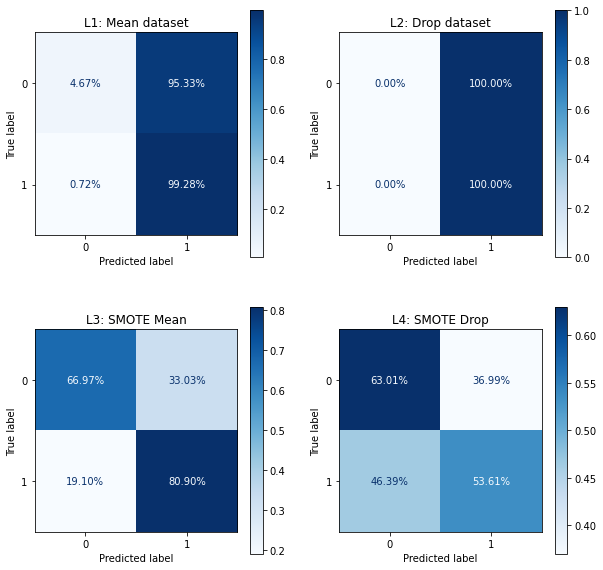

In [24]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(logistic_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(logistic_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(logistic_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(logistic_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('L1: Mean dataset')
drop.set_title('L2: Drop dataset')
smote_mean.set_title('L3: SMOTE Mean')
smote_drop.set_title('L4: SMOTE Drop')

## 4.2 <a class="anchor" id="knn">K Nearest Neighbours</a>
K Nearest Neighbours (KNN) è un algoritmo utilizzato nel riconoscimento di pattern per classificare oggetti in base alle caratteristiche degli oggetti vicini a quello considerato. Un punto è classificato in base alla similarità dei $K$ punti più vicini ad esso. La scelta del parametro $K$ dipende dalle caratteristiche dei dati. Generalmente, all'aumentare di $K$, il rumore che compromette la classificazione si riduce, ma il criterio di scelta per la classe diventa più approssimativo. La scelta può essere fatta attraverso tecniche euristiche. Il modo migliore per creare un modello accurato è utilizzare la *cross-validation* per selezionare il valore ottimale di $K$.

In [25]:
K_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [26]:
# dataset mean
neigh = np.arange(4, 20)
parameters = {'n_neighbors': neigh}
knn_mean = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1')
knn_mean = knn_mean.fit(X_train_mean, y_train_mean)
knn_predict = knn_mean.predict(X_test_mean)
metrics.loc["K1"] = get_metrics(['Mean', 'no'], y_test_mean, knn_predict)
K_metrics.loc["K1"] = metrics.loc["K1"]
print("Il parametro ottimale è K = %s con score %0.2f" % (knn_mean.best_params_, knn_mean.best_score_))
metrics.loc["K1"]

Il parametro ottimale è K = {'n_neighbors': 19} con score 0.91


Dataset          Mean
SMOTE              no
Accuracy       0.8312
Precision      0.8449
Sensitivity    0.9753
Specificity    0.1341
F1 Score       0.2315
Name: K1, dtype: object

In [27]:
# dataset drop
neigh = np.arange(4, 20)
parameters = {'n_neighbors': neigh}
knn_drop = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1')
knn_drop = knn_drop.fit(X_train_drop, y_train_drop)
knn_predict = knn_drop.predict(X_test_drop)
metrics.loc["K2"] = get_metrics(['Drop', 'no'], y_test_drop, knn_predict)
K_metrics.loc["K2"] = metrics.loc["K2"]
print("Il parametro ottimale è K = %s con score %0.2f" % (knn_drop.best_params_, knn_drop.best_score_))
metrics.loc["K2"]

Il parametro ottimale è K = {'n_neighbors': 17} con score 0.96


Dataset          Drop
SMOTE              no
Accuracy       0.9253
Precision      0.9253
Sensitivity         1
Specificity         0
F1 Score            0
Name: K2, dtype: object

In [28]:
# dataset mean SMOTE
neigh = np.arange(4, 20)
parameters = {'n_neighbors': neigh}
knn_mean_smote = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1')
knn_mean_smote = knn_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
knn_predict = knn_mean_smote.predict(X_test_mean)
metrics.loc["K3"] = get_metrics(['Mean', 'yes'], y_test_mean, knn_predict)
K_metrics.loc["K3"] = metrics.loc["K3"]
print("Il parametro ottimale è K = %s con score %0.2f" % (knn_mean_smote.best_params_, knn_mean_smote.best_score_))
metrics.loc["K3"]

Il parametro ottimale è K = {'n_neighbors': 5} con score 0.76


Dataset          Mean
SMOTE             yes
Accuracy       0.6509
Precision      0.8809
Sensitivity    0.6693
Specificity    0.5621
F1 Score       0.6863
Name: K3, dtype: object

In [29]:
# dataset drop SMOTE
neigh = np.arange(4, 20)
parameters = {'n_neighbors': neigh}
knn_drop_smote = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1')
knn_drop_smote = knn_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
knn_predict = knn_drop_smote.predict(X_test_drop)
metrics.loc["K4"] = get_metrics(['Drop', 'yes'], y_test_drop, knn_predict)
K_metrics.loc["K4"] = metrics.loc["K4"]
print("Il parametro ottimale è K = %s con score %0.2f" % (knn_drop_smote.best_params_, knn_drop_smote.best_score_))
metrics.loc["K4"]

Il parametro ottimale è K = {'n_neighbors': 5} con score 0.78


Dataset          Drop
SMOTE             yes
Accuracy       0.6805
Precision      0.9272
Sensitivity    0.7104
Specificity    0.3092
F1 Score       0.4637
Name: K4, dtype: object

In [30]:
K_metrics.sort_values('F1 Score')

,Dataset,SMOTE,Accuracy,Precision,Sensitivity,Specificity,F1 Score
K2,Drop,no,0.9253,0.9253,1.0000,0.0000,0.0000
K1,Mean,no,0.8312,0.8449,0.9753,0.1341,0.2315
K4,Drop,yes,0.6805,0.9272,0.7104,0.3092,0.4637
K3,Mean,yes,0.6509,0.8809,0.6693,0.5621,0.6863


Text(0.5, 1.0, 'K4: SMOTE Drop')

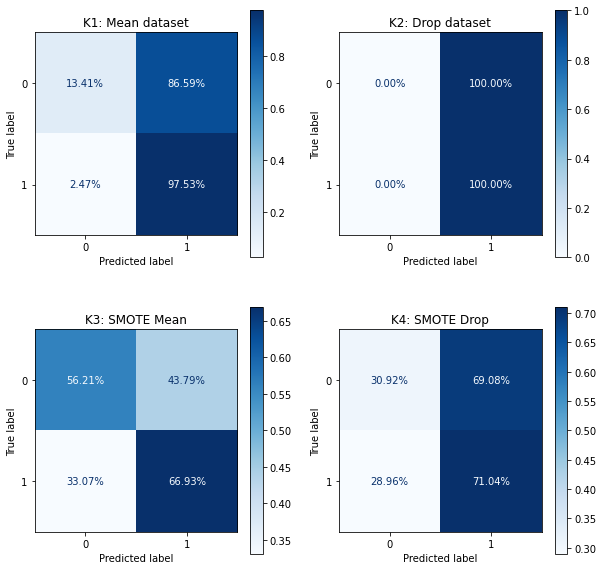

In [31]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(knn_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(knn_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(knn_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(knn_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('K1: Mean dataset')
drop.set_title('K2: Drop dataset')
smote_mean.set_title('K3: SMOTE Mean')
smote_drop.set_title('K4: SMOTE Drop')

## 4.3 <a class="anchor" id="svm">Support vector machines </a>
Il modello di base Support-Vector Machine (SVM) trova l'iperpiano ottimale tra i punti di due classi in modo tale da massimizzare la distanza dei punti più vicini al limite di decisione.

Chiaramente, non è scontato avere una separazione lineare, difatti SVM può essere generalizzato.

Questa generalizzazione può essere effettuata scegliendo una funzione Kernel non lineare da applicare alla SVM.

SVM usa generalmente come kernel lineare:
$$ k({\vec{x_i}},{\vec{x_{j}}})={\vec{x_{i}}}\cdot{\vec{x_{j}}}$$

L'alternativa non lineare forse più comune è il kernel base radiale:
$${k({\vec{x_i},\vec{x_{j}}})=\exp(-\gamma \|{\vec {x_{i}}}-{\vec {x_{j}}}\|^{2})}$$
dove ${\gamma \gt 0}$ è un parametro da scegliere. Questa la funzione kernel predefinita nella libreria usata.

Fondamentalmente, il kernel mappa i dati in un altro spazio in cui la classe può essere separata linearmente, mentre nello spazio originale, il confine sarà generalmente non lineare.

In [32]:
S_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [33]:
#dataset mean
c = 0.01
svm_mean = svm.SVC(gamma = 'auto', C = c, kernel = "rbf", random_state = SEED)
svm_mean = svm_mean.fit(X_train_mean, y_train_mean)
svm_mod_predict = svm_mean.predict(X_test_mean)
metrics.loc["S1"] = get_metrics(['Mean', 'no'], y_test_mean, svm_mod_predict)
S_metrics.loc["S1"] = metrics.loc["S1"]
metrics.loc["S1"]

Dataset          Mean
SMOTE              no
Accuracy       0.8287
Precision      0.8287
Sensitivity         1
Specificity         0
F1 Score            0
Name: S1, dtype: object

In [34]:
#dataset drop
c = 0.01
svm_drop = svm.SVC(gamma = 'auto', C = c, kernel = "rbf", random_state = SEED)
svm_mod = svm_drop.fit(X_train_drop, y_train_drop)
svm_mod_predict = svm_mod.predict(X_test_drop)
metrics.loc["S2"] = get_metrics(['Drop', 'no'], y_test_drop, svm_mod_predict)
S_metrics.loc["S2"] = metrics.loc["S2"]
metrics.loc["S2"]

Dataset          Drop
SMOTE              no
Accuracy       0.9253
Precision      0.9253
Sensitivity         1
Specificity         0
F1 Score            0
Name: S2, dtype: object

In [35]:
#dataset mean SMOTE
c = 0.01
svm_mean_smote = svm.SVC(gamma = 'auto', C = c, kernel = "rbf", random_state = SEED)
svm_mean_smote = svm_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
svm_mod_predict = svm_mean_smote.predict(X_test_mean)
metrics.loc["S3"] = get_metrics(['Mean', 'yes'], y_test_mean, svm_mod_predict)
S_metrics.loc["S3"] = metrics.loc["S3"]
metrics.loc["S3"]

Dataset          Mean
SMOTE             yes
Accuracy       0.8213
Precision      0.8495
Sensitivity    0.9532
Specificity    0.1833
F1 Score       0.3015
Name: S3, dtype: object

In [36]:
#dataset drop SMOTE
c = 0.01
svm_drop_smote = svm.SVC(gamma = 'auto', C = c, kernel = "rbf", random_state = SEED)
svm_drop_smote = svm_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
svm_mod_predict = svm_drop_smote.predict(X_test_drop)
metrics.loc["S4"] = get_metrics(['Drop', 'yes'], y_test_drop, svm_mod_predict)
S_metrics.loc["S4"] = metrics.loc["S4"]
metrics.loc["S4"]

Dataset          Drop
SMOTE             yes
Accuracy       0.9068
Precision      0.9271
Sensitivity     0.976
Specificity    0.0489
F1 Score       0.0929
Name: S4, dtype: object

In [37]:
S_metrics.sort_values('F1 Score')

,Dataset,SMOTE,Accuracy,Precision,Sensitivity,Specificity,F1 Score
S1,Mean,no,0.8287,0.8287,1.0000,0.0000,0.0000
S2,Drop,no,0.9253,0.9253,1.0000,0.0000,0.0000
S4,Drop,yes,0.9068,0.9271,0.9760,0.0489,0.0929
S3,Mean,yes,0.8213,0.8495,0.9532,0.1833,0.3015


Text(0.5, 1.0, 'S4: SMOTE Drop')

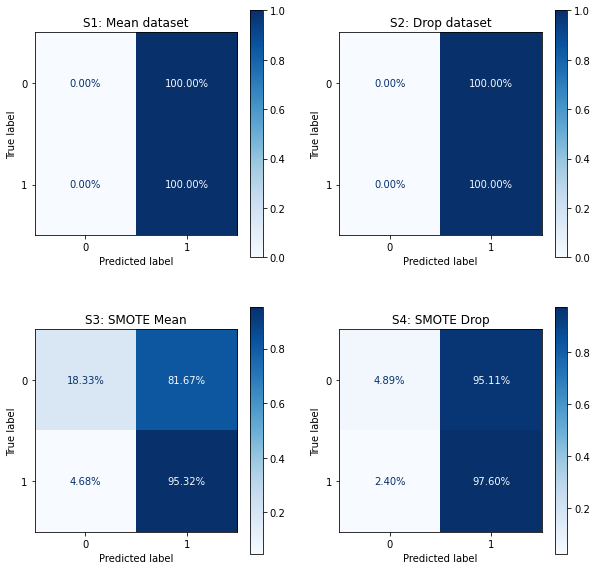

In [38]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(svm_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(svm_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(svm_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(svm_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('S1: Mean dataset')
drop.set_title('S2: Drop dataset')
smote_mean.set_title('S3: SMOTE Mean')
smote_drop.set_title('S4: SMOTE Drop')

## 4.4 <a class="anchor" id="tree">Alberi di decisione</a>
Un albero di decisione è un modello molto comune per i problemi di classificazione (è anche chiamato albero di classificazione). Descrive una struttura ad albero in cui i nodi foglia rappresentano le classificazioni e le ramificazioni l'insieme delle proprietà che portano a tali classificazioni. 

In molte situazioni è utile definire un criterio di arresto o un criterio di potatura per determinarne la profondità massima. Questo perché la profondità crescente di un albero (o le sue dimensioni) non influisce direttamente sulla bontà del modello. Infatti, una crescita eccessiva delle dimensioni dell'albero potrebbe solo portare ad un aumento sproporzionato della complessità computazionale rispetto ai benefici riguardanti l'accuratezza delle previsioni.

L'algoritmo sceglie ad ogni passaggio la variabile che divide meglio l'insieme di elementi, secondo determinate metriche.

I parametri utilizzati principalmente per guidare la costruzione dell'albero sono l'indice di Gini e la devianza dell'Entropia.

L'indice di Gini è calcolato come: 
$$ GI(t) = 1-\sum_{j=1}^k p(j|t)^2$$

La devianza dell'Entropia come:
$$ Entropy(t) = -\sum_{j=1}^k p(j|t)log_2(p(j|t))$$
$\forall \text{ node } t$, dove $p(j|t)$ è la frequenza relativa della classe $j$ al nodo $t$.

In [39]:
depth = np.arange(4, 15) # for trees and forests
parameters = {'max_depth': depth}

#### Entropia

In [40]:
TE_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [41]:
#dataset mean
#Entropy criterion
tree_Entropy_mean = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1')
tree_Entropy_mean = tree_Entropy_mean.fit(X_train_mean, y_train_mean)
tree_Entropy_pred = tree_Entropy_mean.predict(X_test_mean)
metrics.loc["TE1"] = get_metrics(['Mean', 'no'], y_test_mean, tree_Entropy_pred)
TE_metrics.loc["TE1"] = metrics.loc["TE1"]
print("Il miglior parametro per l'albero di decisione con criterio Entropia è" + 
     "%s con score %0.2f" % (tree_Entropy_mean.best_params_, tree_Entropy_mean.best_score_))
metrics.loc["TE1"]

Il miglior parametro per l'albero di decisione con criterio Entropia è{'max_depth': 4} con score 0.91


Dataset          Mean
SMOTE              no
Accuracy       0.8348
Precision      0.8536
Sensitivity    0.9664
Specificity     0.198
F1 Score       0.3214
Name: TE1, dtype: object

In [42]:
#dataset drop
#Entropy criterion
tree_Entropy_drop = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1')
tree_Entropy_drop = tree_Entropy_drop.fit(X_train_drop, y_train_drop)
tree_Entropy_pred = tree_Entropy_drop.predict(X_test_drop)
metrics.loc["TE2"] = get_metrics(['Drop', 'no'], y_test_drop, tree_Entropy_pred)
TE_metrics.loc["TE2"] = metrics.loc["TE2"]
print("Il miglior parametro per l'albero di decisione con criterio Entropia è" + 
     "%s con score %0.2f" % (tree_Entropy_drop.best_params_, tree_Entropy_drop.best_score_))
metrics.loc["TE2"]

Il miglior parametro per l'albero di decisione con criterio Entropia è{'max_depth': 4} con score 0.96


Dataset          Drop
SMOTE              no
Accuracy        0.925
Precision      0.9253
Sensitivity    0.9997
Specificity         0
F1 Score            0
Name: TE2, dtype: object

In [43]:
#dataset mean SMOTE
#Entropy criterion
tree_Entropy_mean_smote = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1')
tree_Entropy_mean_smote = tree_Entropy_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
tree_Entropy_pred = tree_Entropy_mean_smote.predict(X_test_mean)
metrics.loc["TE3"] = get_metrics(['Mean', 'yes'], y_test_mean, tree_Entropy_pred)
TE_metrics.loc["TE3"] = metrics.loc["TE3"]
print("Il miglior parametro per l'albero di decisione con criterio Entropia è" + 
     "%s con score %0.2f" % (tree_Entropy_mean_smote.best_params_, tree_Entropy_mean_smote.best_score_))
metrics.loc["TE3"]

Il miglior parametro per l'albero di decisione con criterio Entropia è{'max_depth': 13} con score 0.87


Dataset          Mean
SMOTE             yes
Accuracy       0.8052
Precision      0.9065
Sensitivity    0.8529
Specificity    0.5744
F1 Score       0.7032
Name: TE3, dtype: object

In [44]:
#dataset drop SMOTE
#Entropy criterion
tree_Entropy_drop_smote = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1')
tree_Entropy_drop_smote = tree_Entropy_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
tree_Entropy_pred = tree_Entropy_drop_smote.predict(X_test_drop)
metrics.loc["TE4"] = get_metrics(['Drop', 'yes'], y_test_drop, tree_Entropy_pred)
TE_metrics.loc["TE4"] = metrics.loc["TE4"]
print("Il miglior parametro per l'albero di decisione con criterio Entropia è" + 
     "%s con score %0.2f" % (tree_Entropy_drop_smote.best_params_, tree_Entropy_drop_smote.best_score_))
metrics.loc["TE4"]

Il miglior parametro per l'albero di decisione con criterio Entropia è{'max_depth': 14} con score 0.89


Dataset          Drop
SMOTE             yes
Accuracy       0.9008
Precision      0.9243
Sensitivity    0.9724
Specificity    0.0137
F1 Score        0.027
Name: TE4, dtype: object

In [45]:
TE_metrics.sort_values('F1 Score')

,Dataset,SMOTE,Accuracy,Precision,Sensitivity,Specificity,F1 Score
TE2,Drop,no,0.9250,0.9253,0.9997,0.0000,0.0000
TE4,Drop,yes,0.9008,0.9243,0.9724,0.0137,0.0270
TE1,Mean,no,0.8348,0.8536,0.9664,0.1980,0.3214
TE3,Mean,yes,0.8052,0.9065,0.8529,0.5744,0.7032


Text(0.5, 1.0, 'TE4: SMOTE Drop')

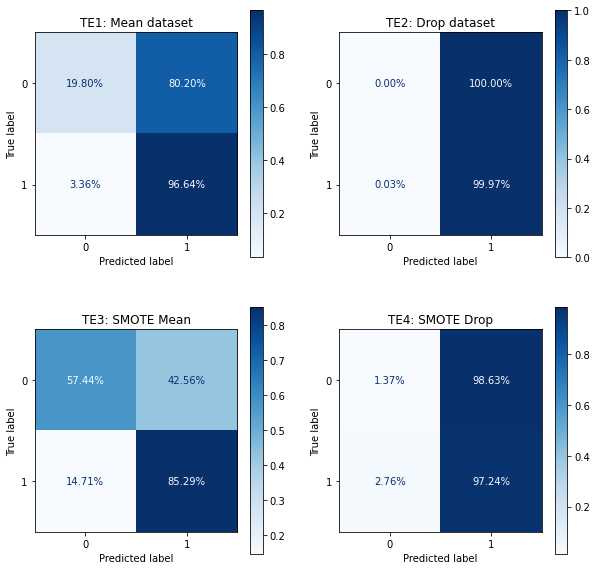

In [46]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(tree_Entropy_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(tree_Entropy_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(tree_Entropy_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(tree_Entropy_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('TE1: Mean dataset')
drop.set_title('TE2: Drop dataset')
smote_mean.set_title('TE3: SMOTE Mean')
smote_drop.set_title('TE4: SMOTE Drop')

#### Gini

In [47]:
TG_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [48]:
#dataset mean
#Gini criterion
tree_Gini_mean = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1')
tree_Gini_mean = tree_Gini_mean.fit(X_train_mean, y_train_mean)
tree_Gini_pred = tree_Gini_mean.predict(X_test_mean)
metrics.loc["TG1"] = get_metrics(['Mean', 'no'], y_test_mean, tree_Gini_pred)
TG_metrics.loc["TG1"] = metrics.loc["TG1"]
print("Il miglior parametro per l'albero di decisione con criterio Gini è" + 
     "%s con score %0.2f" % (tree_Gini_mean.best_params_, tree_Gini_mean.best_score_))
metrics.loc["TG1"]

Il miglior parametro per l'albero di decisione con criterio Gini è{'max_depth': 4} con score 0.91


Dataset          Mean
SMOTE              no
Accuracy       0.8347
Precision      0.8535
Sensitivity    0.9663
Specificity     0.198
F1 Score       0.3214
Name: TG1, dtype: object

In [49]:
#dataset drop
#Gini criterion
tree_Gini_drop = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1')
tree_Gini_drop = tree_Gini_drop.fit(X_train_drop, y_train_drop)
tree_Gini_pred = tree_Gini_drop.predict(X_test_drop)
metrics.loc["TG2"] = get_metrics(['Drop', 'no'], y_test_drop, tree_Gini_pred)
TG_metrics.loc["TG2"] = metrics.loc["TG2"]
print("Il miglior parametro per l'albero di decisione con criterio Gini è" + 
     "%s con score %0.2f" % (tree_Gini_drop.best_params_, tree_Gini_drop.best_score_))
metrics.loc["TG2"]

Il miglior parametro per l'albero di decisione con criterio Gini è{'max_depth': 4} con score 0.96


Dataset          Drop
SMOTE              no
Accuracy       0.9253
Precision      0.9253
Sensitivity         1
Specificity         0
F1 Score            0
Name: TG2, dtype: object

In [50]:
#dataset mean SMOTE
#Gini criterion
tree_Gini_mean_smote = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1')
tree_Gini_mean_smote = tree_Gini_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
tree_Gini_pred = tree_Gini_mean_smote.predict(X_test_mean)
metrics.loc["TG3"] = get_metrics(['Mean', 'yes'], y_test_mean, tree_Gini_pred)
TG_metrics.loc["TG3"] = metrics.loc["TG3"]
print("Il miglior parametro per l'albero di decisione con criterio Gini è" + 
     "%s con score %0.2f" % (tree_Gini_mean_smote.best_params_, tree_Gini_mean_smote.best_score_))
metrics.loc["TG3"]

Il miglior parametro per l'albero di decisione con criterio Gini è{'max_depth': 11} con score 0.87


Dataset          Mean
SMOTE             yes
Accuracy       0.8085
Precision      0.9067
Sensitivity    0.8571
Specificity    0.5732
F1 Score       0.7024
Name: TG3, dtype: object

In [51]:
#dataset drop SMOTE
#Gini criterion
tree_Gini_drop_smote = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1')
tree_Gini_drop_smote = tree_Gini_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
tree_Gini_pred = tree_Gini_drop_smote.predict(X_test_drop)
metrics.loc["TG4"] = get_metrics(['Drop', 'yes'], y_test_drop, tree_Gini_pred)
TG_metrics.loc["TG4"] = metrics.loc["TG4"]
print("Il miglior parametro per l'albero di decisione con criterio Gini è" + 
     "%s con score %0.2f" % (tree_Gini_drop_smote.best_params_, tree_Gini_drop_smote.best_score_))
metrics.loc["TG4"]

Il miglior parametro per l'albero di decisione con criterio Gini è{'max_depth': 14} con score 0.89


Dataset          Drop
SMOTE             yes
Accuracy       0.8837
Precision      0.9259
Sensitivity    0.9504
Specificity    0.0568
F1 Score        0.107
Name: TG4, dtype: object

In [52]:
TG_metrics.sort_values('F1 Score')

,Dataset,SMOTE,Accuracy,Precision,Sensitivity,Specificity,F1 Score
TG2,Drop,no,0.9253,0.9253,1.0000,0.0000,0.0000
TG4,Drop,yes,0.8837,0.9259,0.9504,0.0568,0.1070
TG1,Mean,no,0.8347,0.8535,0.9663,0.1980,0.3214
TG3,Mean,yes,0.8085,0.9067,0.8571,0.5732,0.7024


Text(0.5, 1.0, 'TG4: SMOTE Drop')

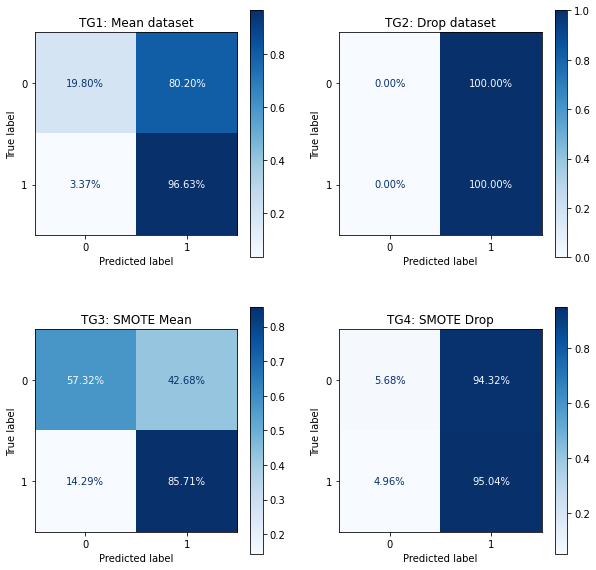

In [53]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(tree_Gini_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(tree_Gini_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(tree_Gini_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(tree_Gini_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('TG1: Mean dataset')
drop.set_title('TG2: Drop dataset')
smote_mean.set_title('TG3: SMOTE Mean')
smote_drop.set_title('TG4: SMOTE Drop')

## 4.5 <a class="anchor" id="forest">Random forest</a>
Come può suggerire il nome, il Random forest viene ottenuto usando in parallelo diversi alberi di decisioni contemporaneamente.

L'idea generale è di applicare un numero (ragionevolmente grande) di alberi di decisione su sottocampioni diversi e infine decidere l'etichetta a maggioranza. Applicare gli alberi su insiemi diversi è una soluzione per minimizzare l'adattamento eccessivo ai dati, grande pecca degli alberi di decisione.


In [54]:
# Random forest
parameters = {'max_depth': depth}

### Entropia

In [55]:
FE_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [56]:
#dataset mean
#Entropy criterion
forest_Entropy_mean = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'entropy', 
                                                     random_state = SEED), parameters, scoring = 'f1')
forest_Entropy_mean = forest_Entropy_mean.fit(X_train_mean, y_train_mean)
forest_Entropy_pred = forest_Entropy_mean.predict(X_test_mean)
metrics.loc["FE1"] = get_metrics(['Mean', 'no'], y_test_mean, forest_Entropy_pred)
FE_metrics.loc["FE1"] = metrics.loc["FE1"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Entropy_mean.best_params_, forest_Entropy_mean.best_score_))
metrics.loc["FE1"]

I parametri ottimali per Random Forest sono {'max_depth': 5} con score 0.91


Dataset          Mean
SMOTE              no
Accuracy       0.8337
Precision      0.8427
Sensitivity    0.9828
Specificity    0.1125
F1 Score       0.1985
Name: FE1, dtype: object

In [57]:
#dataset drop
#Entropy criterion
forest_Entropy_drop = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'entropy', 
                                                     random_state = SEED), parameters, scoring = 'f1')
forest_Entropy_drop = forest_Entropy_drop.fit(X_train_drop, y_train_drop)
forest_Entropy_pred = forest_Entropy_drop.predict(X_test_drop)
metrics.loc["FE2"] = get_metrics(['Drop', 'no'], y_test_drop, forest_Entropy_pred)
FE_metrics.loc["FE2"] = metrics.loc["FE2"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Entropy_drop.best_params_, forest_Entropy_drop.best_score_))
metrics.loc["FE2"]

I parametri ottimali per Random Forest sono {'max_depth': 4} con score 0.96


Dataset          Drop
SMOTE              no
Accuracy       0.9253
Precision      0.9253
Sensitivity         1
Specificity         0
F1 Score            0
Name: FE2, dtype: object

In [58]:
#dataset mean SMOTE
#Entropy criterion
forest_Entropy_mean_smote = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'entropy', 
                                                     random_state = SEED), parameters, scoring = 'f1')
forest_Entropy_mean_smote = forest_Entropy_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
forest_Entropy_pred = forest_Entropy_mean_smote.predict(X_test_mean)
metrics.loc["FE3"] = get_metrics(['Mean', 'yes'], y_test_mean, forest_Entropy_pred)
FE_metrics.loc["FE3"] = metrics.loc["FE3"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Entropy_mean_smote.best_params_, forest_Entropy_mean_smote.best_score_))
metrics.loc["FE3"]

I parametri ottimali per Random Forest sono {'max_depth': 14} con score 0.87


Dataset          Mean
SMOTE             yes
Accuracy       0.8131
Precision      0.9075
Sensitivity    0.8623
Specificity     0.575
F1 Score        0.704
Name: FE3, dtype: object

In [59]:
#dataset drop SMOTE
#Entropy criterion
forest_Entropy_drop_smote = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'entropy', 
                                                     random_state = SEED), parameters, scoring = 'f1')
forest_Entropy_drop_smote = forest_Entropy_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
forest_Entropy_pred = forest_Entropy_drop.predict(X_test_drop)
metrics.loc["FE4"] = get_metrics(['Drop', 'yes'], y_test_drop, forest_Entropy_pred)
FE_metrics.loc["FE4"] = metrics.loc["FE4"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Entropy_drop_smote.best_params_, forest_Entropy_drop_smote.best_score_))
metrics.loc["FE4"]

I parametri ottimali per Random Forest sono {'max_depth': 14} con score 0.93


Dataset          Drop
SMOTE             yes
Accuracy       0.9253
Precision      0.9253
Sensitivity         1
Specificity         0
F1 Score            0
Name: FE4, dtype: object

In [60]:
FE_metrics.sort_values('F1 Score')

,Dataset,SMOTE,Accuracy,Precision,Sensitivity,Specificity,F1 Score
FE2,Drop,no,0.9253,0.9253,1.0000,0.0000,0.0000
FE4,Drop,yes,0.9253,0.9253,1.0000,0.0000,0.0000
FE1,Mean,no,0.8337,0.8427,0.9828,0.1125,0.1985
FE3,Mean,yes,0.8131,0.9075,0.8623,0.5750,0.7040


Text(0.5, 1.0, 'FE4: SMOTE Drop')

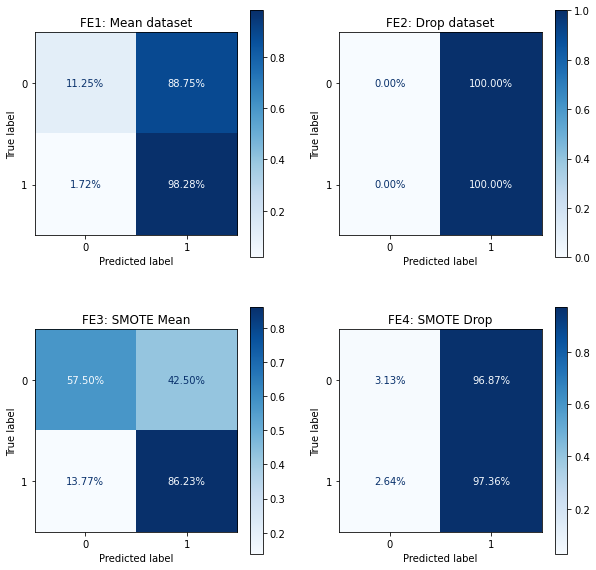

In [61]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(forest_Entropy_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(forest_Entropy_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(forest_Entropy_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(forest_Entropy_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('FE1: Mean dataset')
drop.set_title('FE2: Drop dataset')
smote_mean.set_title('FE3: SMOTE Mean')
smote_drop.set_title('FE4: SMOTE Drop')

### Gini

In [62]:
FG_metrics = pd.DataFrame(columns = ['Dataset', 'SMOTE', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'])

In [63]:
#dataset mean
#Gini criterion
forest_Gini_mean = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'gini', 
                                                  random_state = SEED), parameters, scoring = 'f1')
forest_Gini_mean = forest_Gini_mean.fit(X_train_mean, y_train_mean)
forest_Gini_pred = forest_Gini_mean.predict(X_test_mean)
metrics.loc["FG1"] = get_metrics(['Mean', 'no'], y_test_mean, forest_Gini_pred)
FG_metrics.loc["FG1"] = metrics.loc["FG1"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Gini_mean.best_params_, forest_Gini_mean.best_score_))
metrics.loc["FG1"]

I parametri ottimali per Random Forest sono {'max_depth': 5} con score 0.91


Dataset          Mean
SMOTE              no
Accuracy       0.8336
Precision      0.8416
Sensitivity    0.9846
Specificity    0.1033
F1 Score        0.184
Name: FG1, dtype: object

In [ ]:
#dataset drop
#Gini criterion
forest_Gini_drop = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'gini', 
                                                  random_state = SEED), parameters, scoring = 'f1')
forest_Gini_drop = forest_Gini_drop.fit(X_train_drop, y_train_drop)
forest_Gini_pred = forest_Gini_drop.predict(X_test_drop)
metrics.loc["FG2"] = get_metrics(['Drop', 'no'], y_test_drop, forest_Gini_pred)
FG_metrics.loc["FG2"] = metrics.loc["FG2"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Gini_drop.best_params_, forest_Gini_drop.best_score_))
metrics.loc["FG2"]

In [ ]:
#dataset mean SMOTE
#Gini criterion
forest_Gini_mean_smote = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'gini', 
                                                  random_state = SEED), parameters, scoring = 'f1')
forest_Gini_mean_smote = forest_Gini_mean_smote.fit(X_SMOTE_mean, y_SMOTE_mean)
forest_Gini_pred = forest_Gini_mean_smote.predict(X_test_mean)
metrics.loc["FG3"] = get_metrics(['Mean', 'yes'], y_test_mean, forest_Gini_pred)
FG_metrics.loc["FG3"] = metrics.loc["FG3"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Gini_mean_smote.best_params_, forest_Gini_mean_smote.best_score_))
metrics.loc["FG3"]

In [ ]:
#dataset drop SMOTE
#Gini criterion
forest_Gini_drop_smote = GridSearchCV(RandomForestClassifier(n_estimators = 100, criterion = 'gini', 
                                                  random_state = SEED), parameters, scoring = 'f1')
forest_Gini_drop_smote = forest_Gini_drop_smote.fit(X_SMOTE_drop, y_SMOTE_drop)
forest_Gini_pred = forest_Gini_drop_smote.predict(X_test_drop)
metrics.loc["FG4"] = get_metrics(['Drop', 'yes'], y_test_drop, forest_Gini_pred)
FG_metrics.loc["FG4"] = metrics.loc["FG4"]
print("I parametri ottimali per Random Forest sono %s con score %0.2f" % 
      (forest_Gini_drop_smote.best_params_, forest_Gini_drop_smote.best_score_))
metrics.loc["FG4"] 

In [ ]:
FG_metrics.sort_values('F1 Score')

In [ ]:
fig, ((mean, drop), (smote_mean, smote_drop)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_confusion_matrix(forest_Gini_mean, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true', 
                      ax = mean)
plot_confusion_matrix(forest_Gini_drop, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = drop)
plot_confusion_matrix(forest_Gini_mean_smote, X_test_mean, y_test_mean,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_mean)
plot_confusion_matrix(forest_Gini_drop_smote, X_test_drop, y_test_drop,
                      cmap = plt.cm.Blues, values_format = '0.2%', normalize = 'true',
                      ax = smote_drop)
mean.set_title('FG1: Mean dataset')
drop.set_title('FG2: Drop dataset')
smote_mean.set_title('FG3: SMOTE Mean')
smote_drop.set_title('FG4: SMOTE Drop')

# 5. <a class="anchor" id="conclusioni">Conclusioni</a>
Come visto usando tutti gli algoritmi, il fatto che il dataset fosse molto sbilanciato ha un forte impatto sui modelli: molti hanno *accuracy* e *sensitivy* vicinissime o addirittura pari a 1, ma *specificity* vicinissima o pari a 0. Ciò è dovuto al fatto che questi algoritmi tenevano ad assegnare tutti i record alla classe 1, quella maggioritaria, come è chiaro dalle *confusion matrix*.

Ordiniamo i modelli usati in base a *F1 score*, metrica più completa delle altre. Emerge subito che l'*oversampling* ha ripagato significativamente: tutti i modelli che superano lo 0.5 di *F1 score* sono stati addestrati sul dataset costruito con l'algoritmo *SMOTE*.

Per quanto riguarda la gestione dei valori mancanti, l'approccio basato sulla sostituzione col valore medio ha performato molto meglio dell'idea di rimuovere i record incompleti.

Tra gli algoritmi, la *regressione logistica* primeggia su tutte, lavorando bene anche sul dataset in cui sono stati rimossi i record con valori mancanti.
Anche *random forest* e *alberi di decisione*, quando applicati al dataset *SMOTE* con approccio "valore medio", raggiungono uno score di 0.7.

In [ ]:
metrics.sort_values('F1 Score', ascending = False)